In [1]:
import sys
sys.path.append("..")

from methods.dcbo import DynCausalBayesOpt
from utils.sequential_sampling import draw_samples_from_sem_dev
from causal_graph.example_dyn_graphs import three_step_stat
from sem.stationary import StationaryModel_dev
from collections import OrderedDict
from utils.costs import equal_cost
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from collections import OrderedDict
tfd = tfp.distributions
tf.random.set_seed(0)

In [2]:
sem_model = StationaryModel_dev()
num_samples = 50
temporal_index = 2
full_samples = OrderedDict([(key, []) for key in sem_model.static().keys()])
epsilon = OrderedDict(
    [
        (key, tfd.Normal(0.0, 0.1).sample((num_samples, temporal_index+1)))
        for key in full_samples.keys()
    ]
)

epsilon_x1 = tf.linspace(-3.0, 5.0, num_samples)[:, tf.newaxis]
epsilon_x23 = tfd.Normal(0.0, 0.1).sample((num_samples, 2))
epsilon["X"] = tf.concat([epsilon_x1, epsilon_x23], axis=1)
D_obs = draw_samples_from_sem_dev(sem_model, num_samples, temporal_index, epsilon=epsilon)

In [3]:
dyn_graph = three_step_stat()
# D_obs = draw_samples_from_sem_dev(sem_model, num_samples, temporal_index)

intervention_ini = {
    "X": [-0.6],
    "Z": [None],
    "Y": [None],
}
D_intervene_ini_x = draw_samples_from_sem_dev(
    sem_model, 1, 0, intervention=intervention_ini, epsilon=0.0
)

intervention_ini = {
    "X": [None],
    "Z": [1.0],
    "Y": [None],
}
D_intervene_ini_z = draw_samples_from_sem_dev(
    sem_model, 1, 0, intervention=intervention_ini, epsilon=0.0
)
D_intervene_ini = OrderedDict(
    [(("X",), D_intervene_ini_x), (("Z",), D_intervene_ini_z)]
)
intervention_domain = OrderedDict([("X", [-3.0, 5.0]), ("Z", [-5.0, 20.0])])
num_trials = 20
task = "min"
cost_fn = equal_cost
num_anchor_points = 100
num_monte_carlo = 100
jitter = 1e-6
dcbo = DynCausalBayesOpt(
    dyn_graph,
    sem_model,
    D_obs,
    D_intervene_ini,
    intervention_domain,
    num_trials,
    task,
    cost_fn,
    num_anchor_points,
    num_monte_carlo,
    jitter,
)

In [4]:
opt_history = dcbo.run()

Early stopping at step 13782
Early stopping at step 11763
Early stopping at step 11763
Dynamic causal Bayesian optimization at time step 0 is started.
Early stopping at step 4489
Early stopping at step 2140
Temporal index: 0 . Trial: 0
Intervened exploration set: ('Z',) . Intervention point: [[2.9915104]]
Target variable value: -1.8498323
Optimal value: -1.8498323
Early stopping at step 4489
Early stopping at step 4356
Temporal index: 0 . Trial: 1
Intervened exploration set: ('X',) . Intervention point: [[-2.2276125]]
Target variable value: -1.6180382
Optimal value: -1.8498323
Early stopping at step 2749
Early stopping at step 4356
Temporal index: 0 . Trial: 2
Intervened exploration set: ('Z',) . Intervention point: [[9.454311]]
Target variable value: -1.6228713
Optimal value: -1.8498323
Early stopping at step 2749
Early stopping at step 3895
Temporal index: 0 . Trial: 3
Intervened exploration set: ('X',) . Intervention point: [[-1.1576958]]
Target variable value: -1.8520455
Optimal va

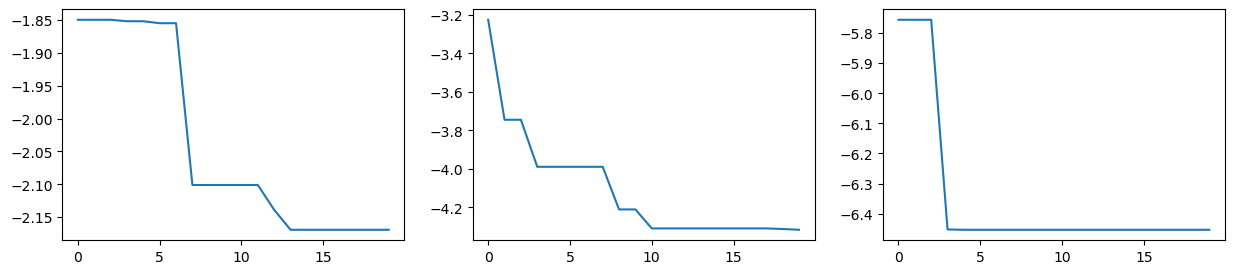

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for i in range(3):
    axs[i].plot(opt_history[i])
plt.show()